# 📓 Quantum Machine Learning Workshop
Welcome to this hands-on workshop on **Quantum Machine Learning (QML)**!  

In this notebook we will:  
1. Explore **data encoding techniques**:  
   - Basis Encoding  
   - Amplitude Encoding  
   - Angle Encoding  
2. Build a simple **Variational Quantum Classifier (VQC)** on a toy dataset.  

---
## 1. Data Encoding in Quantum Computing

##### Quantum computers require classical data to be transformed into **quantum states**.  
##### There are several encoding strategies. Let's explore three of the most common.
---

In [1]:
# --- Required libraries ---
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_bloch_multivector, plot_histogram
import numpy as np
import matplotlib.pyplot as plt

### 🔹 1.1 Basis Encoding
Each classical bitstring is mapped directly to a computational basis state.  

Example:  
- `00 → |00>`  
- `11 → |11>`  

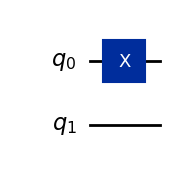

In [2]:
# Example: encode the classical vector [0,1] as |01>
qc_basis = QuantumCircuit(2)
qc_basis.x(0)  # Apply X to flip the first qubit → |01>
qc_basis.draw("mpl")

### 🔹 1.2 Amplitude Encoding
The entries of a normalized vector are used as amplitudes of a quantum state.  

Example: $[x_0, x_1, x_2, x_3] \rightarrow \sum x_i |i>$  

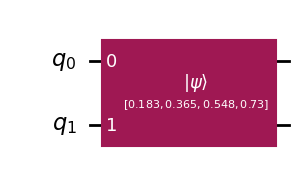

In [3]:
# Classical data vector
data = np.array([1, 2, 3, 4], dtype=float)

# Normalize (required for quantum states)
norm_data = data / np.linalg.norm(data)

# Encode into 2 qubits (4-dimensional state space)
qc_amp = QuantumCircuit(2)
qc_amp.initialize(norm_data, [0,1])
qc_amp.draw("mpl")

### 🔹 1.3 Angle Encoding
Each data feature is mapped to the angle of a rotation gate.  

Example: $x \mapsto R_y(x)$  

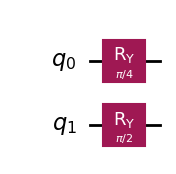

In [4]:
# Example with 2 classical features
features = [np.pi/4, np.pi/2]

qc_angle = QuantumCircuit(2)
qc_angle.ry(features[0], 0)
qc_angle.ry(features[1], 1)
qc_angle.draw("mpl")

### 🔹 1.4 High-Order Quantum Encoding
High-Order Encoding maps not only the raw features but also their products (polynomial terms) into qubit rotations.  

Example with 2 features \((x_1, x_2)\):  
- Encode \(x_1, x_2\) directly as before.  
- Also encode interaction terms like \(x_1 \cdot x_2\).  


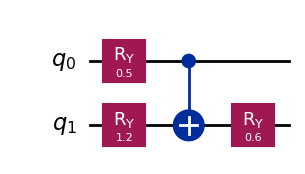

In [5]:
qc = QuantumCircuit(2)
x1, x2 = 0.5, 1.2
qc.ry(x1, 0)
qc.ry(x2, 1)
qc.cx(0,1)
qc.ry(x1*x2, 1)
qc.draw('mpl')

### 🔹 1.4 Visualizing States (Bloch Sphere)
Let's see how encoding affects quantum states on the Bloch sphere.

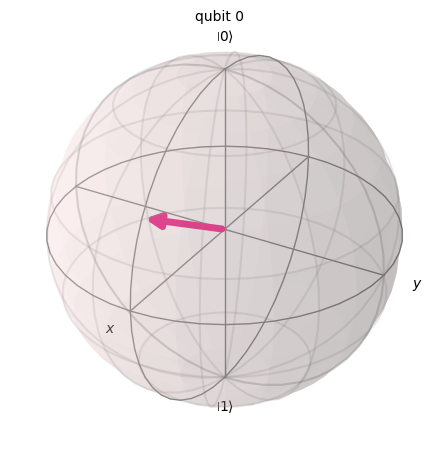

In [6]:
def show_bloch(qc):
    backend = Aer.get_backend("statevector_simulator")
    compiled_circuit = transpile(qc, backend)
    job = backend.run(compiled_circuit)
    result = job.result()
    state = result.get_statevector()
    return plot_bloch_multivector(state)

# Single-qubit example with angle encoding
qc_angle_1q = QuantumCircuit(1)
qc_angle_1q.ry(np.pi/3, 0)
qc_angle_1q.draw("mpl")
show_bloch(qc_angle_1q)

---
## 2. Variational Quantum Classifier (VQC)

Now let’s build a simple **quantum classifier**.  
We’ll:  
1. Generate a toy dataset.  
2. Encode data using **Angle Encoding**.  
3. Build a variational circuit (ansatz).  
4. Train with a classical optimizer.
---

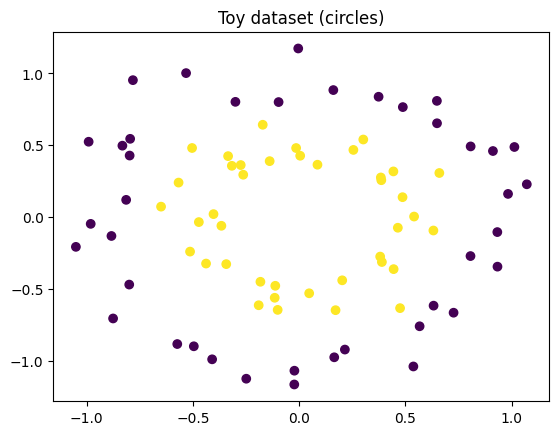

In [7]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

# Dataset: two concentric circles (nonlinear)
X, y = make_circles(n_samples=80, noise=0.1, factor=0.5, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

plt.figure()
plt.scatter(X[:,0], X[:,1], c=y)
plt.title('Toy dataset (circles)')
plt.show()

### 🔹 2.1 Feature Map (Angle Encoding)
We’ll encode 2D points $(x_1, x_2)$ into two qubits using angle encoding.

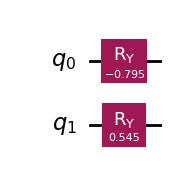

In [8]:
def feature_map(x):
    qc = QuantumCircuit(2)
    qc.ry(x[0], 0)
    qc.ry(x[1], 1)
    return qc

# Preview encoding for one sample
feature_map(X_train[0]).draw('mpl')

### 🔹 2.2 Variational Ansatz — Step A: First rotation layer
Two parameterized rotations, one per qubit (θ₁, θ₂).

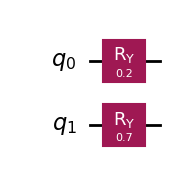

In [9]:
def layer1(params):
    qc = QuantumCircuit(2)
    qc.ry(params[0], 0)
    qc.ry(params[1], 1)
    return qc

theta_demo = np.array([0.2, 0.7, 0.4, 1.1])
layer1(theta_demo).draw('mpl')

### 🔹 2.3 Variational Ansatz — Step B: Entanglement layer
Create correlations with a CNOT (CX).

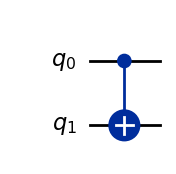

In [10]:
def entangle():
    qc = QuantumCircuit(2)
    qc.cx(0, 1)
    return qc

entangle().draw('mpl')

### 🔹 2.4 Variational Ansatz — Step C: Second rotation layer
Another set of parameterized rotations (θ₃, θ₄).

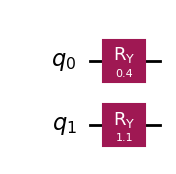

In [11]:
def layer2(params):
    qc = QuantumCircuit(2)
    qc.ry(params[2], 0)
    qc.ry(params[3], 1)
    return qc

layer2(theta_demo).draw('mpl')

### 🔹 2.5 Variational Ansatz — Step D: Assemble the full ansatz
Combine **Layer1 → Entangle → Layer2**.

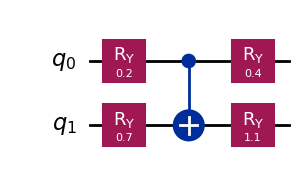

In [13]:
def variational_circuit(params):
    qc = QuantumCircuit(2)
    qc = qc.compose(layer1(params))
    qc = qc.compose(entangle())
    qc = qc.compose(layer2(params))
    return qc

variational_circuit(theta_demo).draw('mpl')

### 🔹 2.3 Prediction Function
We’ll compute the expectation value of Z on qubit 0 and turn it into a binary prediction.

In [14]:
backend = Aer.get_backend('qasm_simulator')

def classify(x, params, shots=512):
    qc = QuantumCircuit(2, 1)
    qc = qc.compose(feature_map(x))
    qc = qc.compose(variational_circuit(params))
    qc.measure(0, 0)
    compiled_circuit = transpile(qc, backend)
    job = backend.run(compiled_circuit, shots=shots)
    result = job.result()
    counts = result.get_counts()
    return 1 if counts.get('1', 0) > counts.get('0', 0) else 0

# Quick sanity check
classify(X_train[0], theta_demo)

0

### 🔹 2.4 Loss Function 
We use misclassification rate as loss

In [15]:
def loss(params, X, y):
    preds = [classify(x, params) for x in X]
    return np.mean(preds != y)

loss(theta_demo, X_train[:10], y_train[:10])

np.float64(0.4)

## 3) Training with Gradient-Based Optimizer (SPSA)
We try to import Qiskit's SPSA optimizer. If unavailable, we fall back to a minimal **manual SPSA** implementation.

In [16]:
use_qiskit_spsa = False
try:
    from qiskit.algorithms.optimizers import SPSA
    use_qiskit_spsa = True
except Exception:
    use_qiskit_spsa = False

def objective(p):
    return loss(p, X_train, y_train)

np.random.seed(0)
init_params = np.random.uniform(0, 2*np.pi, 4)

train_losses = []
opt_params = None

if use_qiskit_spsa:
    optimizer = SPSA(maxiter=30)
    # Hook to capture loss per iteration (SPSA doesn't expose a callback directly in all versions)
    # We'll approximate by evaluating the objective on the last params each iter using manual loop if needed.
    result = optimizer.minimize(fun=objective, x0=init_params)
    opt_params = result.x
    # Reconstruct a simple loss history (optional): evaluate a few times around optimum
    train_losses = [objective(opt_params) for _ in range(5)]
else:
    # Manual SPSA
    def spsa_minimize(fun, x0, maxiter=30, a=0.2, c=0.2, alpha=0.602, gamma=0.101):
        x = x0.astype(float).copy()
        history = []
        for k in range(1, maxiter+1):
            ak = a / (k ** alpha)
            ck = c / (k ** gamma)
            delta = 2*np.random.randint(0,2,size=x.shape) - 1  # ±1 vector
            x_plus = x + ck*delta
            x_minus = x - ck*delta
            y_plus = fun(x_plus)
            y_minus = fun(x_minus)
            ghat = (y_plus - y_minus) / (2.0 * ck * delta)
            x = x - ak * ghat
            history.append(fun(x))
        return x, history

    opt_params, train_losses = spsa_minimize(objective, init_params, maxiter=30)

print('Optimized parameters:', opt_params)
print('Final training loss:', objective(opt_params))

Optimized parameters: [3.49245868 4.45840944 3.74311226 3.42236921]
Final training loss: 0.4642857142857143


### 🔹 3.1 Plot training loss

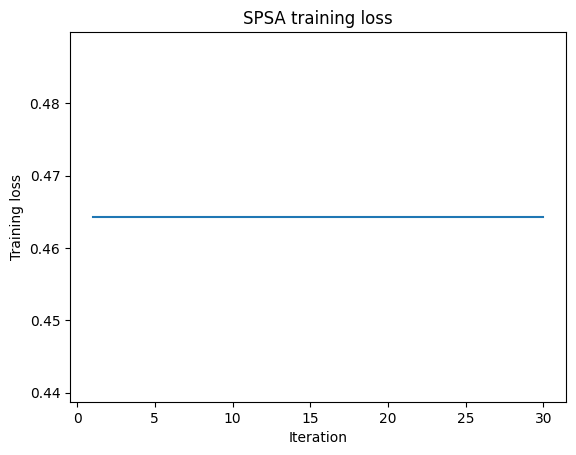

In [17]:
if len(train_losses) > 0:
    plt.figure()
    plt.plot(range(1, len(train_losses)+1), train_losses)
    plt.xlabel('Iteration')
    plt.ylabel('Training loss')
    plt.title('SPSA training loss')
    plt.show()

## 4) Evaluation on test set

In [18]:
preds = [classify(x, opt_params) for x in X_test]
acc = np.mean(preds == y_test)
print(f'Test accuracy: {acc:.2f}')

Test accuracy: 0.42


---
## Summary
In this notebook we:
- Learned **Basis, Amplitude, and Angle encoding** for data.  
- Built a simple **Variational Quantum Classifier (VQC)**.  
- Trained it on a toy dataset using a classical optimizer.  

This is the foundation of **Quantum Machine Learning**: classical data → quantum encoding → variational circuits → hybrid training.